In [1]:
import sys
sys.path.insert(0, r'D:\GitHub\pynotebook\ipymodules\HW')
import holtwinters as hw
import numpy as np
import scipy.stats
from math import sqrt
%matplotlib inline
import pandas as pd
from datetime import timedelta
from scipy import signal
from scipy.optimize import fmin_l_bfgs_b

In [368]:
test = pd.read_csv(r'C:\Users\lenovo\Downloads//chart (4).csv', index_col='DateTime', parse_dates=True)
#test.sort_index(inplace=True)

#test.index = pd.date_range(np.datetime64(test.index[0]), np.datetime64(test.index[0]) + 
#                           np.timedelta64(test.shape[0]-1, 'D'), freq='d')
test.columns = ['NDVI','NDVI_rec']
test = test.resample('d',how='mean')
test.interpolate(method='linear', order=3, inplace=True)
test.head()

,NDVI,NDVI_rec
DateTime,,
2001-01-17,0.432900,0.435165
2001-01-18,0.433156,0.434604
2001-01-19,0.433413,0.434044
2001-01-20,0.433669,0.433483
2001-01-21,0.433925,0.432922


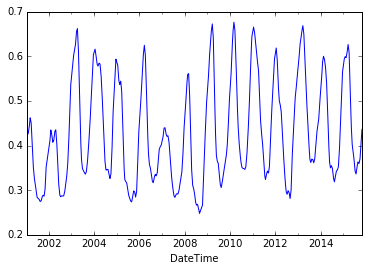

In [369]:
test.NDVI_rec.plot()

In [640]:
data = test.NDVI_rec.as_matrix()
data = data.tolist()
fcast_days = 900

In [685]:
#middle_predictions, alpha, beta, gamma, rmse = hw.multiplicative(data,365, fcast_days, alpha = 0.04, beta = 0.0, gamma=0.01)
middle_predictions, alpha, beta, gamma, rmse = hw.additive(signal.detrend(test.NDVI_rec).tolist(),
                                                                 365, fcast_days, alpha = 0.0001, beta = 0.0001, gamma=0.95)

In [686]:
pred_error_level = 0.95
cum_error = [beta+alpha]
for k in range(1,fcast_days):
    cum_error.append(cum_error[k-1] + k*beta + alpha)

cum_error = np.array(cum_error)
#Use some numpy multiplication to get the intervals
var = cum_error * rmse**2
# find the correct ppf on the normal distribution (two-sided)
p = abs(scipy.stats.norm.ppf((1 - pred_error_level)/2))
interval = np.sqrt(var) * p
upper = middle_predictions + interval
lower = middle_predictions - interval

In [687]:
df = pd.DataFrame(data=[np.asarray(middle_predictions), lower,upper]).T
df.set_index(pd.date_range(test.index[-1],test.index[-1] + timedelta(days=fcast_days), freq='d')[1::], inplace = True) 
df.columns = ['middle','lower','upper']

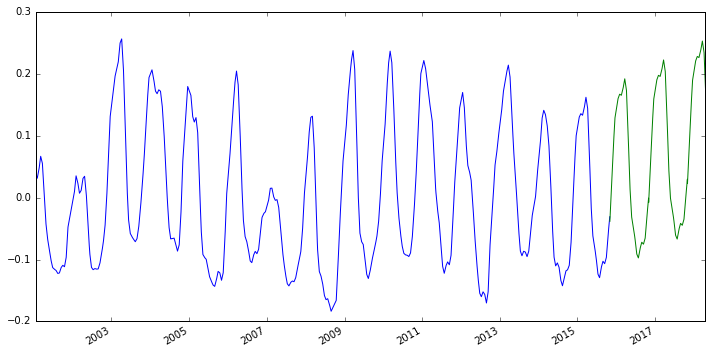

In [688]:
plt.figure(figsize=(10,5))
#test.NDVI_rec.plot()
plt.plot(test.index,signal.detrend(test.NDVI_rec))
df.middle.plot()
#df.lower.plot()
#df.upper.plot()
plt.tight_layout()

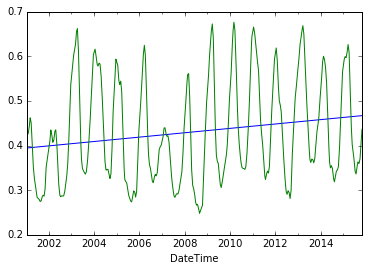

In [692]:
(test.NDVI_rec - signal.detrend(test.NDVI_rec)).plot()
test.NDVI_rec.plot()

SKLEARN FORECASTING LINEAR REGRESSION

In [920]:
from sklearn import svm
from sklearn.linear_model import LinearRegression

In [821]:
test = pd.read_csv(r'C:\Users\lenovo\Downloads//chart (5).csv', index_col='DateTime', parse_dates=True)
#test.sort_index(inplace=True)

#test.index = pd.date_range(np.datetime64(test.index[0]), np.datetime64(test.index[0]) + 
#                           np.timedelta64(test.shape[0]-1, 'D'), freq='d')
#test.columns = ['NDVI','NDVI_rec']
test = test.resample('d',how='mean')
test.interpolate(method='linear', order=3, inplace=True)
test.head()

,VCI,TCI,VHI,NVAI,NTAI
DateTime,,,,,
2001-01-01,0,0.325515,0.162757,-0.514166,0.125721
2001-01-02,0,0.302463,0.151232,-0.514224,0.138736
2001-01-03,0,0.280760,0.140380,-0.514282,0.150990
2001-01-04,0,0.260290,0.130145,-0.514341,0.162548
2001-01-05,0,0.240952,0.120476,-0.514400,0.173467


In [822]:
alpha = 0.5
NDAI = (alpha * test.NVAI ) - ((1-alpha) * test.NTAI)

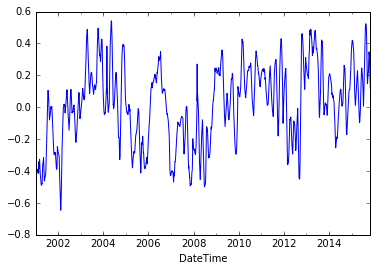

In [1435]:
NDAI.plot()

In [1056]:
to_forecast =  NDAI.values
dates = NDAI.index.values

In [1438]:
to_forecast1 = np.round(NDAI[0:20].values,5)
to_forecast2 = np.round(NDAI[20:40].values,5)
#X_input1.shape == X_input2.shape
k=4
h=1
X1,y1 = organize_data(to_forecast1, k, h)

In [1444]:
y2

array([-0.3931 , -0.39265, -0.39226, -0.39193, -0.39165, -0.39143,
       -0.39127, -0.39116, -0.39051, -0.3893 , -0.39163, -0.39407,
       -0.39662, -0.39929, -0.4021 , -0.40506])

In [1394]:
h = 14  # forecast horizon
k = h*2   # number of previous observations to use
X_,y_ = organize_data(to_forecast, k, h)
dates_ = dates[k+h-1::]
m = int(np.round(y_.shape[0]/2.)) # number of samples to take in account is 50%

In [1414]:
y_2 = np.vstack((y_,y_))
X_2 = np.vstack((X_[None],X_[None]))

In [1418]:
model = sm.OLS(y_2[:m], X_2[:m])
#results = model.fit()
#predictions = results.predict(X_[m:])

ValueError: exog is not 1d or 2d

In [1386]:
model = sm.OLS(y_[:m], X_[:m])
results = model.fit()
predictions = results.predict(X_[m:])

In [1387]:
from statsmodels.sandbox.regression.predstd import wls_prediction_std
prstd, iv_l, iv_u = wls_prediction_std(results, X_[m:])

(2689L,) (2689L,) (2689L,)


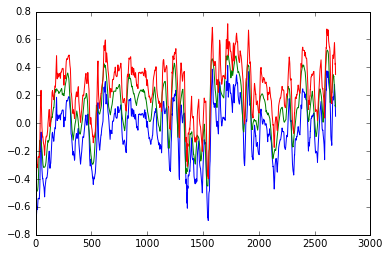

In [1393]:
print iv_l.shape, y_[m:].shape, iv_u.shape
plt.plot(iv_l)
plt.plot(y_[m:])
plt.plot(iv_u)

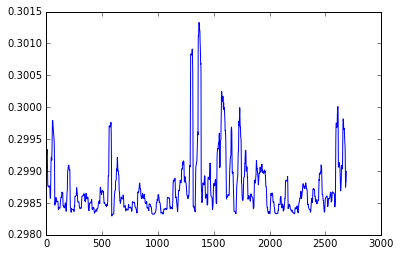

In [1390]:
plt.plot(iv_u - iv_l)

In [1391]:
0.2 - -0.1

0.30000000000000004

In [1419]:
# linear
# m = 460 # number of samples to take in account
m = int(np.round(y14.shape[0]/2.)) # number of samples to take in account is 50%
regressor = LinearRegression(n_jobs=1)
#regressor = svm.SVR(kernel='linear')
#regressor.fit(X[:m], y[:m])

# # # poly degree 3
# # m = 460 # number of samples to take in account
# m = np.round(y.shape[0]/2.) # number of samples to take in account is 50%
# #regressor = LinearRegression(n_jobs=1)
#regressor = svm.SVR(kernel='rbf')
#regressor = svm.SVR(kernel='rbf')
regressor.fit(X14[:m], y14[:m])

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [1420]:
regressor.fit(X_2[:m], y_2[:m])
regressor.score()

ValueError: Found array with dim 3. Estimator expected <= 2.

In [1338]:
r_2 = np.round(regressor.score(X14[:m],y14[:m]),3)
print 'The R^2 error is: '+str(r_2)

The R^2 error is: 0.903


In [1354]:
.shape

(5378L,)

In [1351]:
prstd, iv_l, iv_u = wls_prediction_std(results)
st, data, ss2 = summary_table(results, alpha=0.05)

0.0
0.0
0.0


ValueError: x and y must have same first dimension

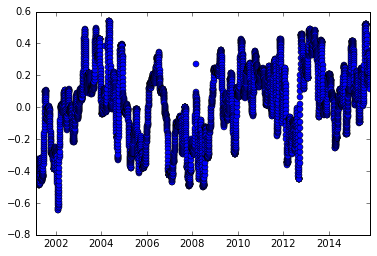

In [1352]:
fittedvalues = data[:,2]
predict_mean_se  = data[:,3]
predict_mean_ci_low, predict_mean_ci_upp = data[:,4:6].T
predict_ci_low, predict_ci_upp = data[:,6:8].T

# check we got the right things
print np.max(np.abs(results.fittedvalues - fittedvalues))
print np.max(np.abs(iv_l - predict_ci_low))
print np.max(np.abs(iv_u - predict_ci_upp))

plt.plot(dates14, y14, 'o')
plt.plot(dates14, fittedvalues, '-', lw=2)
plt.plot(dates14, predict_ci_low, 'g--', lw=2)
plt.plot(dates14, predict_ci_upp, 'g--', lw=2)
plt.plot(dates14, predict_mean_ci_low, 'r--', lw=2)
plt.plot(dates14, predict_mean_ci_upp, 'r--', lw=2)
plt.show()

In [1355]:
import numpy as np
import statsmodels.api as sm
from statsmodels.sandbox.regression.predstd import wls_prediction_std

#measurements genre
nmuestra = 100

x = np.linspace(0, 10, nmuestra)
e = np.random.normal(size=nmuestra)
y = 1 + 0.5*x + 2*e
X = sm.add_constant(x)

re = sm.OLS(y, X).fit()
print re.summary()    #print the result type Stata

prstd, iv_l, iv_u = wls_prediction_std(re)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.307
Model:                            OLS   Adj. R-squared:                  0.300
Method:                 Least Squares   F-statistic:                     43.51
Date:                Wed, 23 Dec 2015   Prob (F-statistic):           2.15e-09
Time:                        16:31:23   Log-Likelihood:                -216.21
No. Observations:                 100   AIC:                             436.4
Df Residuals:                      98   BIC:                             441.6
Df Model:                           1                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const          1.0588      0.422      2.511      0.014         0.222     1.896
x1             0.4805      0.073      6.596      0.0

In [1358]:
from statsmodels.stats.outliers_influence import summary_table

st, data, ss2 = summary_table(re, alpha=0.05)

fittedvalues = data[:,2]
predict_mean_se  = data[:,3]
predict_mean_ci_low, predict_mean_ci_upp = data[:,4:6].T
predict_ci_low, predict_ci_upp = data[:,6:8].T

# check we got the right things
print np.max(np.abs(re.fittedvalues - fittedvalues))
print np.max(np.abs(iv_l - predict_ci_low))
print np.max(np.abs(iv_u - predict_ci_upp))

plt.plot(x, y, 'o')
plt.plot(x, fittedvalues, '-', lw=2)
plt.plot(x, predict_ci_low, 'g--', lw=2)
plt.plot(x, predict_ci_upp, 'g--', lw=2)
plt.plot(x, predict_mean_ci_low, 'r--', lw=2)
plt.plot(x, predict_mean_ci_upp, 'r--', lw=2)
plt.show()

0.0
0.0
0.0


ValueError: x and y must have same first dimension

Error in callback <function post_execute at 0x0000000013E604A8> (for post_execute):


ValueError: ordinal must be >= 1

ValueError: ordinal must be >= 1

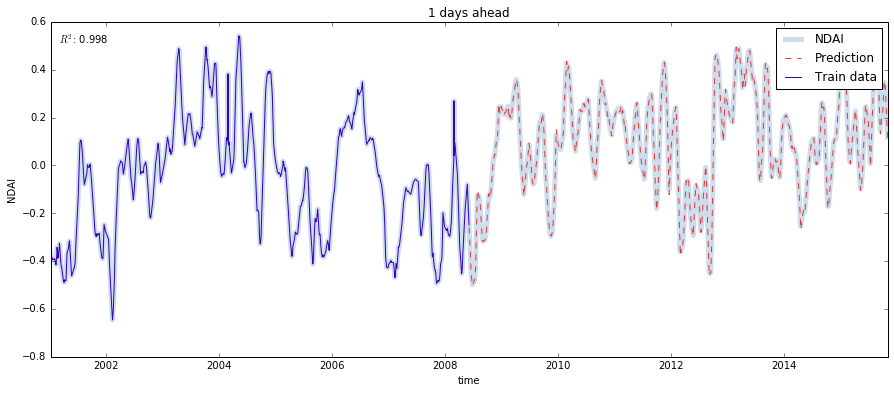

In [1236]:
f = plt.figure(figsize=(15,6))
# ax = f.add_subplot(111)
# ax.plot(dates14,y14, label='NDAI', color='#377EB8', linewidth=5, alpha=0.25)
# ax.plot(dates14[m:],regressor.predict(X14[m:]), 
#      '--', color='#EB3737', linewidth=1, label='Prediction')
# ax.plot(dates14[:m],y14[:m], label='Train data', color='#3700B8', linewidth=1)
# #plt.xticks(np.arange(len(dates))[1::4],dates[1::4], rotation=45)
# ax.legend(loc='upper right')
# ax.set_ylabel('NDAI')
# ax.set_xlabel('time')
# plt.text(0.01, 0.95,'$R^2$: '+str(r_2), ha='left', va='center', transform = ax.transAxes)
# plt.title('14 days ahead')

ax = f.add_subplot(111)
ax.plot(dates1,y1, label='NDAI', color='#377EB8', linewidth=5, alpha=0.25)
ax.plot(dates1[m:],regressor.predict(X1[m:]), 
     '--', color='#EB3737', linewidth=1, label='Prediction')
ax.plot(dates1[:m],y1[:m], label='Train data', color='#3700B8', linewidth=1)
#plt.xticks(np.arange(len(dates))[1::4],dates[1::4], rotation=45)
ax.legend(loc='upper right')
ax.set_ylabel('NDAI')
ax.set_xlabel('time')
plt.text(0.01, 0.95,'$R^2$: '+str(r_2), ha='left', va='center', transform = ax.transAxes)
plt.title('1 days ahead')
plt.show()

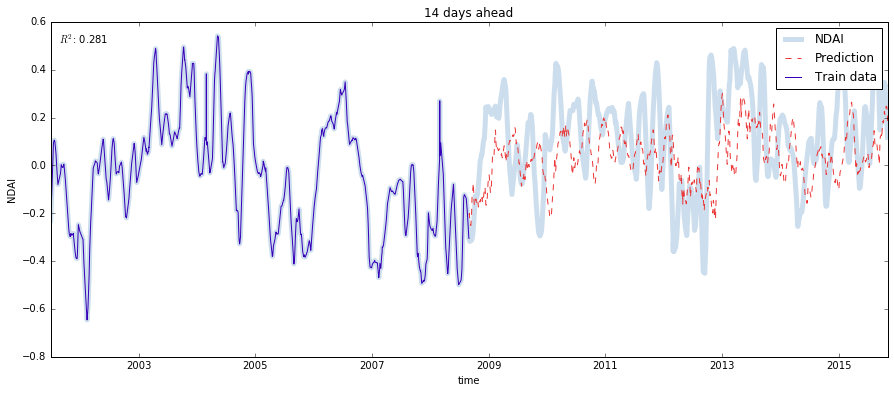

In [1315]:
f = plt.figure(figsize=(15,6))
ax = f.add_subplot(111)
ax.plot(dates14,y14, label='NDAI', color='#377EB8', linewidth=5, alpha=0.25)
ax.plot(dates14[m:],regressor.predict(X14[m:]), 
     '--', color='#EB3737', linewidth=1, label='Prediction')
ax.plot(dates14[:m],y14[:m], label='Train data', color='#3700B8', linewidth=1)
#plt.xticks(np.arange(len(dates))[1::4],dates[1::4], rotation=45)
ax.legend(loc='upper right')
ax.set_ylabel('NDAI')
ax.set_xlabel('time')
plt.text(0.01, 0.95,'$R^2$: '+str(r_2), ha='left', va='center', transform = ax.transAxes)
plt.title('14 days ahead')

In [812]:
X[-1][None]

array([[ 0.42489476,  0.42677535,  0.42865593,  0.43053651]])

# NEW ZEALAND BEER CONSUMPTION TEST CASE

In [707]:
import pandas as pd
folder = r'C:\Users\lenovo\Downloads\TimeSeriesDatasets_130207\TimeSeriesDatasets_130207//'
df = pd.read_csv(folder+'NZAlcoholConsumption.csv')
to_forecast = df.TotalBeer.values
dates = df.DATE.values

In [701]:
import numpy as np

def organize_data(to_forecast, window, horizon):
    """
     Input:
      to_forecast, univariate time series organized as numpy array
      window, number of items to use in the forecast window
      horizon, horizon of the forecast
     Output:
      X, a matrix where each row contains a forecast window
      y, the target values for each row of X
    """
    shape = to_forecast.shape[:-1] + (to_forecast.shape[-1] - window + 1, window)
    strides = to_forecast.strides + (to_forecast.strides[-1],)
    X = np.lib.stride_tricks.as_strided(to_forecast, 
                                        shape=shape, 
                                        strides=strides)
    y = np.array([X[i+horizon][-1] for i in range(len(X)-horizon)])
    return X[:-horizon], y

k = 4   # number of previous observations to use
h = 1   # forecast horizon
X,y = organize_data(to_forecast, k, h)

In [702]:
from sklearn.linear_model import LinearRegression
 
m = 10 # number of samples to take in account
regressor = LinearRegression(normalize=True)
regressor.fit(X[:m], y[:m])

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=True)

In [1087]:
def mape(ypred, ytrue):
    """ returns the mean absolute percentage error """
    idx = ytrue != 0.0
    return 100*np.mean(np.abs(ypred[idx]-ytrue[idx])/ytrue[idx])

print 'The error is %0.2f%%' % mape(regressor.predict(X[m:]),y[m:])

The error is 75.96%


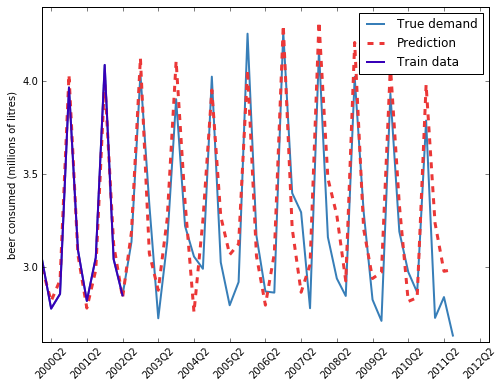

In [706]:
plt.figure(figsize=(8,6))
plt.plot(y, label='True demand', color='#377EB8', linewidth=2)
plt.plot(regressor.predict(X), 
     '--', color='#EB3737', linewidth=3, label='Prediction')
plt.plot(y[:m], label='Train data', color='#3700B8', linewidth=2)
plt.xticks(np.arange(len(dates))[1::4],dates[1::4], rotation=45)
plt.legend(loc='upper right')
plt.ylabel('beer consumed (millions of litres)')
plt.show()

In [728]:
dates

array(['2000Q1', '2000Q2', '2000Q3', '2000Q4', '2001Q1', '2001Q2',
       '2001Q3', '2001Q4', '2002Q1', '2002Q2', '2002Q3', '2002Q4',
       '2003Q1', '2003Q2', '2003Q3', '2003Q4', '2004Q1', '2004Q2',
       '2004Q3', '2004Q4', '2005Q1', '2005Q2', '2005Q3', '2005Q4',
       '2006Q1', '2006Q2', '2006Q3', '2006Q4', '2007Q1', '2007Q2',
       '2007Q3', '2007Q4', '2008Q1', '2008Q2', '2008Q3', '2008Q4',
       '2009Q1', '2009Q2', '2009Q3', '2009Q4', '2010Q1', '2010Q2',
       '2010Q3', '2010Q4', '2011Q1', '2011Q2', '2011Q3', '2011Q4',
       '2012Q1', '2012Q2', '2012Q3'], dtype=object)